In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler

import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample

import warnings
warnings.filterwarnings("ignore")


## READ DATA

In [2]:
df_ts = pd.read_csv('salju_test.csv')
df_tr = pd.read_csv('salju_train.csv')

In [3]:
df_ts.head()

,Tanggal,KodeLokasi,SuhuMin,SuhuMax,Hujan,Penguapan,SinarMatahari,ArahAnginTerkencang,KecepatanAnginTerkencang,ArahAngin9am,ArahAngin3pm,KecepatanAngin9am,KecepatanAngin3pm,Kelembaban9am,Kelembaban3pm,Tekanan9am,Tekanan3pm,Awan9am,Awan3pm,Suhu9am,Suhu3pm,BersaljuHariIni,BersaljuBesok
0,04/11/2010,C39,11.0,27.5,0.0,NaN,6.4,WSW,46.0,W,W,20.0,28.0,39.0,56.0,1013.0,1012.4,4.0,7.0,25.7,23.6,No,No
1,26/03/2015,C35,10.0,19.9,0.2,NaN,NaN,WNW,56.0,W,NW,24.0,33.0,76.0,32.0,1017.0,1015.2,8.0,1.0,10.7,18.9,No,Yes
2,22/03/2016,C18,9.2,27.2,0.0,5.2,10.4,SSW,33.0,NE,N,13.0,19.0,89.0,27.0,1018.6,1015.7,0.0,1.0,13.9,26.3,No,No
3,09/12/2011,C31,17.7,27.0,0.0,4.6,6.7,SW,35.0,E,SSE,20.0,15.0,55.0,41.0,1010.2,1008.6,7.0,6.0,22.3,26.4,No,No
4,20/05/2017,C14,2.3,7.9,88.0,NaN,NaN,NW,46.0,W,WNW,13.0,9.0,98.0,95.0,NaN,NaN,NaN,NaN,4.4,6.0,Yes,No


In [4]:
df_tr.head()

,id,Tanggal,KodeLokasi,SuhuMin,SuhuMax,Hujan,Penguapan,SinarMatahari,ArahAnginTerkencang,KecepatanAnginTerkencang,ArahAngin9am,ArahAngin3pm,KecepatanAngin9am,KecepatanAngin3pm,Kelembaban9am,Kelembaban3pm,Tekanan9am,Tekanan3pm,Awan9am,Awan3pm,Suhu9am,Suhu3pm,BersaljuHariIni,BersaljuBesok
0,1,01/06/2014,C4,10.4,15.5,4.8,NaN,NaN,WSW,24.0,NaN,WSW,0.0,13.0,78.0,76.0,1020.1,1018.5,NaN,NaN,13.1,15.0,Ya,Tidak
1,2,15/07/2014,C10,9.0,17.0,8.0,2.6,7.4,NaN,NaN,SW,WNW,13.0,20.0,80.0,61.0,1015.2,1014.6,7.0,5.0,11.9,15.5,Ya,Ya
2,3,16/02/2011,C46,18.2,32.0,0.0,NaN,NaN,ESE,44.0,SE,SE,15.0,26.0,62.0,42.0,NaN,NaN,NaN,NaN,23.8,29.6,Tidak,Tidak
3,4,08/08/2012,C36,7.3,24.5,0.0,8.4,10.4,SSW,54.0,N,SW,13.0,19.0,25.0,17.0,1019.2,1016.9,1.0,7.0,15.3,23.2,Tidak,Tidak
4,5,29/10/2016,C7,5.9,20.3,0.0,3.6,12.6,N,37.0,NNW,ESE,22.0,19.0,55.0,48.0,1019.7,1014.7,2.0,6.0,12.4,18.1,Tidak,Tidak


In [5]:
df_tr.drop(columns='id', inplace=True)

## EKSPLORASI DATA

Eksplorasi Data Train (Untuk Missing Value, Outliers dan Label Imbalance

In [6]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109095 entries, 0 to 109094
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Tanggal                   109095 non-null  object 
 1   KodeLokasi                109095 non-null  object 
 2   SuhuMin                   107973 non-null  float64
 3   SuhuMax                   108166 non-null  float64
 4   Hujan                     106664 non-null  float64
 5   Penguapan                 62071 non-null   float64
 6   SinarMatahari             56716 non-null   float64
 7   ArahAnginTerkencang       101351 non-null  object 
 8   KecepatanAnginTerkencang  101399 non-null  float64
 9   ArahAngin9am              101172 non-null  object 
 10  ArahAngin3pm              105898 non-null  object 
 11  KecepatanAngin9am         107742 non-null  float64
 12  KecepatanAngin3pm         106792 non-null  float64
 13  Kelembaban9am             107093 non-null  f

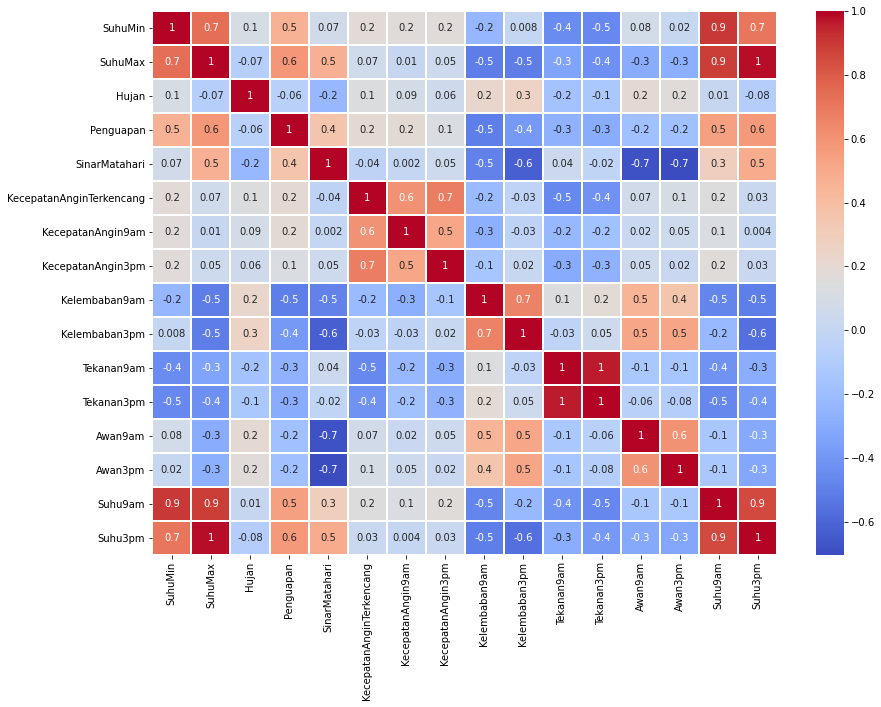

In [7]:
plt.figure(figsize=(14,10))
sns.heatmap(df_tr.corr(),
            cmap='coolwarm',
            annot=True,linewidths=1,
            fmt='.0g');

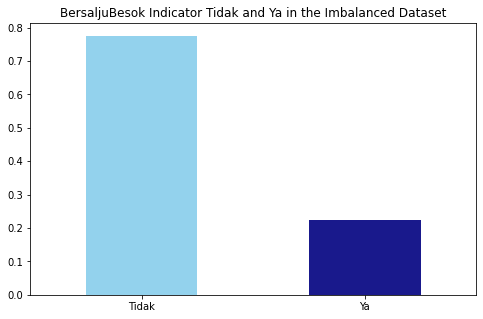

In [8]:
fig = plt.figure(figsize = (8,5))
df_tr['BersaljuBesok'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('BersaljuBesok Indicator Tidak and Ya in the Imbalanced Dataset')
plt.show()

## PREPROCESSING DATA TRAIN dan TEST

Handle Imbalanced Dataset (Data Train & Data Test)

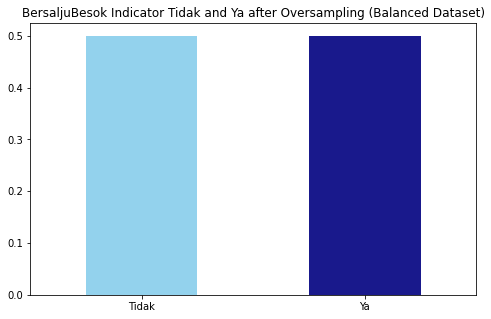

In [9]:
#DATA TRAIN
no = df_tr[df_tr['BersaljuBesok'] == 'Tidak']
yes = df_tr[df_tr['BersaljuBesok'] == 'Ya']
yes_oversampled = resample(yes, replace=True, n_samples=len(no), random_state=123)
oversampled = pd.concat([no, yes_oversampled])

fig = plt.figure(figsize = (8,5))
oversampled['BersaljuBesok'].value_counts(normalize = True).plot(kind='bar', color= ['skyblue','navy'], alpha = 0.9, rot=0)
plt.title('BersaljuBesok Indicator Tidak and Ya after Oversampling (Balanced Dataset)')
plt.show()

In [10]:
#Oversampled to DATA TRAIN
df_tr = oversampled

Handle Missing Value (Data Test dan Data Train)

In [11]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165402 entries, 0 to 49506
Data columns (total 23 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Tanggal                   165402 non-null  object 
 1   KodeLokasi                165402 non-null  object 
 2   SuhuMin                   164615 non-null  float64
 3   SuhuMax                   165044 non-null  float64
 4   Hujan                     163143 non-null  float64
 5   Penguapan                 94476 non-null   float64
 6   SinarMatahari             87227 non-null   float64
 7   ArahAnginTerkencang       153861 non-null  object 
 8   KecepatanAnginTerkencang  153955 non-null  float64
 9   ArahAngin9am              154437 non-null  object 
 10  ArahAngin3pm              160657 non-null  object 
 11  KecepatanAngin9am         163799 non-null  float64
 12  KecepatanAngin3pm         162254 non-null  float64
 13  Kelembaban9am             163103 non-null  fl

In [12]:
# Insert nilai null menjadi nilai mean dari setiap kolom
df_tr.fillna(df_tr.mean(), inplace=True)

df_ts.fillna(df_ts.mean(), inplace=True)

Mengubah Data BersaljuHariIni dan BersaljuBesok menjadi data Numerikal (Data Train dan Data Test)

In [13]:
#DATA TRAIN
df_tr['BersaljuHariIni'].replace({'Tidak': 0, 'Ya': 1},inplace = True)
df_tr['BersaljuBesok'].replace({'Tidak': 0, 'Ya': 1},inplace = True)

#DATA TEST
df_ts['BersaljuHariIni'].replace({'No': 0, 'Yes': 1},inplace = True)
df_ts['BersaljuBesok'].replace({'No': 0, 'Yes': 1},inplace = True)

Handle Missing Value for Data Categorical (Data Test dan Data Train)

In [14]:
# Impute categorical var with Mode
#DATA TRAIN
df_tr['ArahAnginTerkencang'] = df_tr['ArahAnginTerkencang'].fillna(df_tr['ArahAnginTerkencang'].mode()[0])
df_tr['ArahAngin9am'] = df_tr['ArahAngin9am'].fillna(df_tr['ArahAngin9am'].mode()[0])
df_tr['ArahAngin3pm'] = df_tr['ArahAngin3pm'].fillna(df_tr['ArahAngin3pm'].mode()[0])
df_tr['BersaljuHariIni'] = df_tr['BersaljuHariIni'].fillna(df_tr['BersaljuHariIni'].mode()[0])


#DATA TEST
df_ts['ArahAnginTerkencang'] = df_ts['ArahAnginTerkencang'].fillna(df_ts['ArahAnginTerkencang'].mode()[0])
df_ts['ArahAngin9am'] = df_ts['ArahAngin9am'].fillna(df_ts['ArahAngin9am'].mode()[0])
df_ts['ArahAngin3pm'] = df_ts['ArahAngin3pm'].fillna(df_ts['ArahAngin3pm'].mode()[0])
df_ts['BersaljuHariIni'] = df_ts['BersaljuHariIni'].fillna(df_ts['BersaljuHariIni'].mode()[0])

In [15]:
df_tr.head()

,Tanggal,KodeLokasi,SuhuMin,SuhuMax,Hujan,Penguapan,SinarMatahari,ArahAnginTerkencang,KecepatanAnginTerkencang,ArahAngin9am,ArahAngin3pm,KecepatanAngin9am,KecepatanAngin3pm,Kelembaban9am,Kelembaban3pm,Tekanan9am,Tekanan3pm,Awan9am,Awan3pm,Suhu9am,Suhu3pm,BersaljuHariIni,BersaljuBesok
0,01/06/2014,C4,10.4,15.5,4.8,5.12954,6.485839,WSW,24.0,N,WSW,0.0,13.0,78.0,76.0,1020.100000,1018.500000,5.048074,5.186954,13.1,15.0,1.0,0
2,16/02/2011,C46,18.2,32.0,0.0,5.12954,6.485839,ESE,44.0,SE,SE,15.0,26.0,62.0,42.0,1016.497719,1014.210534,5.048074,5.186954,23.8,29.6,0.0,0
3,08/08/2012,C36,7.3,24.5,0.0,8.40000,10.400000,SSW,54.0,N,SW,13.0,19.0,25.0,17.0,1019.200000,1016.900000,1.000000,7.000000,15.3,23.2,0.0,0
4,29/10/2016,C7,5.9,20.3,0.0,3.60000,12.600000,N,37.0,NNW,ESE,22.0,19.0,55.0,48.0,1019.700000,1014.700000,2.000000,6.000000,12.4,18.1,0.0,0
5,12/06/2011,C12,14.4,21.8,0.0,3.20000,4.400000,SW,39.0,SW,SSW,19.0,20.0,63.0,52.0,1016.100000,1012.500000,7.000000,7.000000,16.7,21.1,0.0,0


Mengubah Data Categorical ke Data Numerik (Data Train dan Data Test)

In [16]:
le = LabelEncoder()

#DATA TRAIN
df_tr['KodeLokasi'] = le.fit_transform(df_tr['KodeLokasi'])
df_tr['ArahAnginTerkencang'] = le.fit_transform(df_tr['ArahAnginTerkencang'])
df_tr['ArahAngin9am'] = le.fit_transform(df_tr['ArahAngin9am'])
df_tr['ArahAngin3pm'] = le.fit_transform(df_tr['ArahAngin3pm'])

#DATA TEST
df_ts['KodeLokasi'] = le.fit_transform(df_ts['KodeLokasi'])
df_ts['ArahAnginTerkencang'] = le.fit_transform(df_ts['ArahAnginTerkencang'])
df_ts['ArahAngin9am'] = le.fit_transform(df_ts['ArahAngin9am'])
df_ts['ArahAngin3pm'] = le.fit_transform(df_ts['ArahAngin3pm'])

In [17]:
df_ts['ArahAnginTerkencang'].unique()

array([15, 14, 11, 12,  7, 10,  9,  0, 13,  8,  5,  4,  1,  6,  2,  3])

In [18]:
df_tr.head()

,Tanggal,KodeLokasi,SuhuMin,SuhuMax,Hujan,Penguapan,SinarMatahari,ArahAnginTerkencang,KecepatanAnginTerkencang,ArahAngin9am,ArahAngin3pm,KecepatanAngin9am,KecepatanAngin3pm,Kelembaban9am,Kelembaban3pm,Tekanan9am,Tekanan3pm,Awan9am,Awan3pm,Suhu9am,Suhu3pm,BersaljuHariIni,BersaljuBesok
0,01/06/2014,33,10.4,15.5,4.8,5.12954,6.485839,15,24.0,3,15,0.0,13.0,78.0,76.0,1020.100000,1018.500000,5.048074,5.186954,13.1,15.0,1.0,0
2,16/02/2011,40,18.2,32.0,0.0,5.12954,6.485839,2,44.0,9,9,15.0,26.0,62.0,42.0,1016.497719,1014.210534,5.048074,5.186954,23.8,29.6,0.0,0
3,08/08/2012,29,7.3,24.5,0.0,8.40000,10.400000,11,54.0,3,12,13.0,19.0,25.0,17.0,1019.200000,1016.900000,1.000000,7.000000,15.3,23.2,0.0,0
4,29/10/2016,46,5.9,20.3,0.0,3.60000,12.600000,3,37.0,6,2,22.0,19.0,55.0,48.0,1019.700000,1014.700000,2.000000,6.000000,12.4,18.1,0.0,0
5,12/06/2011,3,14.4,21.8,0.0,3.20000,4.400000,12,39.0,12,11,19.0,20.0,63.0,52.0,1016.100000,1012.500000,7.000000,7.000000,16.7,21.1,0.0,0


In [19]:
df_ts.isna().sum()

Tanggal                       0
KodeLokasi                    0
SuhuMin                       0
SuhuMax                       0
Hujan                         0
Penguapan                     0
SinarMatahari                 0
ArahAnginTerkencang           0
KecepatanAnginTerkencang      0
ArahAngin9am                  0
ArahAngin3pm                  0
KecepatanAngin9am             0
KecepatanAngin3pm             0
Kelembaban9am                 0
Kelembaban3pm                 0
Tekanan9am                    0
Tekanan3pm                    0
Awan9am                       0
Awan3pm                       0
Suhu9am                       0
Suhu3pm                       0
BersaljuHariIni               0
BersaljuBesok               419
dtype: int64

In [20]:
df_tr.head()

,Tanggal,KodeLokasi,SuhuMin,SuhuMax,Hujan,Penguapan,SinarMatahari,ArahAnginTerkencang,KecepatanAnginTerkencang,ArahAngin9am,ArahAngin3pm,KecepatanAngin9am,KecepatanAngin3pm,Kelembaban9am,Kelembaban3pm,Tekanan9am,Tekanan3pm,Awan9am,Awan3pm,Suhu9am,Suhu3pm,BersaljuHariIni,BersaljuBesok
0,01/06/2014,33,10.4,15.5,4.8,5.12954,6.485839,15,24.0,3,15,0.0,13.0,78.0,76.0,1020.100000,1018.500000,5.048074,5.186954,13.1,15.0,1.0,0
2,16/02/2011,40,18.2,32.0,0.0,5.12954,6.485839,2,44.0,9,9,15.0,26.0,62.0,42.0,1016.497719,1014.210534,5.048074,5.186954,23.8,29.6,0.0,0
3,08/08/2012,29,7.3,24.5,0.0,8.40000,10.400000,11,54.0,3,12,13.0,19.0,25.0,17.0,1019.200000,1016.900000,1.000000,7.000000,15.3,23.2,0.0,0
4,29/10/2016,46,5.9,20.3,0.0,3.60000,12.600000,3,37.0,6,2,22.0,19.0,55.0,48.0,1019.700000,1014.700000,2.000000,6.000000,12.4,18.1,0.0,0
5,12/06/2011,3,14.4,21.8,0.0,3.20000,4.400000,12,39.0,12,11,19.0,20.0,63.0,52.0,1016.100000,1012.500000,7.000000,7.000000,16.7,21.1,0.0,0


In [21]:
df_ts.head()

,Tanggal,KodeLokasi,SuhuMin,SuhuMax,Hujan,Penguapan,SinarMatahari,ArahAnginTerkencang,KecepatanAnginTerkencang,ArahAngin9am,ArahAngin3pm,KecepatanAngin9am,KecepatanAngin3pm,Kelembaban9am,Kelembaban3pm,Tekanan9am,Tekanan3pm,Awan9am,Awan3pm,Suhu9am,Suhu3pm,BersaljuHariIni,BersaljuBesok
0,04/11/2010,32,11.0,27.5,0.0,5.509646,6.400000,15,46.0,13,13,20.0,28.0,39.0,56.0,1013.00000,1012.400000,4.00000,7.000000,25.7,23.6,0.0,0.0
1,26/03/2015,28,10.0,19.9,0.2,5.509646,7.630135,14,56.0,13,7,24.0,33.0,76.0,32.0,1017.00000,1015.200000,8.00000,1.000000,10.7,18.9,0.0,1.0
2,22/03/2016,9,9.2,27.2,0.0,5.200000,10.400000,11,33.0,4,3,13.0,19.0,89.0,27.0,1018.60000,1015.700000,0.00000,1.000000,13.9,26.3,0.0,0.0
3,09/12/2011,24,17.7,27.0,0.0,4.600000,6.700000,12,35.0,0,10,20.0,15.0,55.0,41.0,1010.20000,1008.600000,7.00000,6.000000,22.3,26.4,0.0,0.0
4,20/05/2017,5,2.3,7.9,88.0,5.509646,7.630135,7,46.0,13,14,13.0,9.0,98.0,95.0,1017.56166,1015.181064,4.44982,4.498322,4.4,6.0,1.0,0.0


In [22]:
# Drop datetime
df_tr_new = df_tr.drop(['Tanggal'], axis = 1)
df_ts_new = df_ts.drop(['Tanggal'], axis = 1)

# NORMALIZATION DATA TEST & TRAIN (MIN MAX NORMALIZATION)s
df_tr_new = ( (df_tr_new - df_tr_new.min()) / (df_tr_new.max() - df_tr_new.min()) )
df_ts_new = ( (df_ts_new - df_ts_new.min()) / (df_ts_new.max() - df_ts_new.min()) )

# Drop row yang mengandung Missing Values Pada Data Test kolom 'BersaljuBesok'
df_ts_new = df_ts_new.dropna()

## MERAPIHKAN DATA

In [23]:
df_ts_new.head()

,KodeLokasi,SuhuMin,SuhuMax,Hujan,Penguapan,SinarMatahari,ArahAnginTerkencang,KecepatanAnginTerkencang,ArahAngin9am,ArahAngin3pm,KecepatanAngin9am,KecepatanAngin3pm,Kelembaban9am,Kelembaban3pm,Tekanan9am,Tekanan3pm,Awan9am,Awan3pm,Suhu9am,Suhu3pm,BersaljuHariIni,BersaljuBesok
0,0.666667,0.476923,0.592885,0.000000,0.080082,0.441379,1.000000,0.344828,0.866667,0.866667,0.240964,0.337349,0.377551,0.555556,0.526587,0.517625,0.500000,0.87500,0.720280,0.548193,0.0,0.0
1,0.583333,0.451282,0.442688,0.000809,0.080082,0.526216,0.933333,0.431034,0.866667,0.466667,0.289157,0.397590,0.755102,0.313131,0.595197,0.569573,1.000000,0.12500,0.370629,0.453815,0.0,1.0
2,0.187500,0.430769,0.586957,0.000000,0.075581,0.717241,0.733333,0.232759,0.266667,0.200000,0.156627,0.228916,0.887755,0.262626,0.622642,0.578850,0.000000,0.12500,0.445221,0.602410,0.0,0.0
3,0.500000,0.648718,0.583004,0.000000,0.066860,0.462069,0.800000,0.250000,0.000000,0.666667,0.240964,0.180723,0.540816,0.404040,0.478559,0.447124,0.875000,0.75000,0.641026,0.604418,0.0,0.0
4,0.104167,0.253846,0.205534,0.355987,0.080082,0.526216,0.466667,0.344828,0.866667,0.933333,0.156627,0.108434,0.979592,0.949495,0.604831,0.569222,0.556228,0.56229,0.223776,0.194779,1.0,0.0


In [24]:
df_ts_new.isna().sum()

KodeLokasi                  0
SuhuMin                     0
SuhuMax                     0
Hujan                       0
Penguapan                   0
SinarMatahari               0
ArahAnginTerkencang         0
KecepatanAnginTerkencang    0
ArahAngin9am                0
ArahAngin3pm                0
KecepatanAngin9am           0
KecepatanAngin3pm           0
Kelembaban9am               0
Kelembaban3pm               0
Tekanan9am                  0
Tekanan3pm                  0
Awan9am                     0
Awan3pm                     0
Suhu9am                     0
Suhu3pm                     0
BersaljuHariIni             0
BersaljuBesok               0
dtype: int64

## MACHINE LEARNING (PEMBUATAN MODEL)

Import Library

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.naive_bayes import GaussianNB

from sklearn import svm

Pemisahan Parameter dan Label terhadap Data Train dan Data Test

In [26]:
x_train = df_tr_new.drop(['BersaljuBesok'], axis=1)
y_train = df_tr_new['BersaljuBesok']

x_test = df_ts_new.drop(['BersaljuBesok'], axis=1)
y_test = df_ts_new['BersaljuBesok']

## Logistic Regression

In [27]:
# Bentuk Model
modelLR = LogisticRegression()
modelLR.fit(x_train, y_train)
# Predict
y_predLR = modelLR.predict(x_test)

In [28]:
print(classification_report(y_test, y_predLR))

              precision    recall  f1-score   support

         0.0       0.94      0.72      0.82     13824
         1.0       0.46      0.84      0.59      3939

    accuracy                           0.75     17763
   macro avg       0.70      0.78      0.71     17763
weighted avg       0.83      0.75      0.77     17763



## Naive Bayes

sumber : https://www.datacamp.com/community/tutorials/naive-bayes-scikit-learn?utm_source=adwords_ppc&utm_campaignid=1455363063&utm_adgroupid=65083631748&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=&utm_creative=332602034364&utm_targetid=aud-299261629614:dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=1007716&gclid=Cj0KCQjwwLKFBhDPARIsAPzPi-I0nEHdUY0WNpBrBKEA10PYyI3S20sSDFKAkx0cmJtenwAIdC9zPAgaAkTAEALw_wcB

In [29]:
#Bentuk Model
modelNB = GaussianNB()
modelNB.fit(x_train, y_train)
#Predict
y_predNB = modelNB.predict(x_test)

In [30]:
print(classification_report(y_test, y_predNB))

              precision    recall  f1-score   support

         0.0       0.89      0.81      0.85     13824
         1.0       0.49      0.66      0.56      3939

    accuracy                           0.77     17763
   macro avg       0.69      0.73      0.71     17763
weighted avg       0.80      0.77      0.78     17763



## SVM (Support Vector Machine)

In [31]:
#Bentuk Model
modelSVM = svm.SVC(kernel='linear')
modelSVM.fit(x_train, y_train)
#Predict
y_predSVM = modelSVM.predict(x_test)

In [32]:
print(classification_report(y_test, y_predSVM))

              precision    recall  f1-score   support

         0.0       0.94      0.71      0.81     13824
         1.0       0.45      0.85      0.59      3939

    accuracy                           0.74     17763
   macro avg       0.70      0.78      0.70     17763
weighted avg       0.83      0.74      0.76     17763

